# Part 3: Modelling with TensorFlow

Do note that you have to use an environment with Tensorflow installed to run this notebook.

In this section, I will be attempting to use neural network to create the predictive model.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    train_test_split,
)

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [210]:
# Importing datasets
model_cat_a = pd.read_csv('../data/merged_cat_a.csv')
model_cat_a_lag = pd.read_csv('../data/merged_cat_a_lag.csv')

In [211]:
# Convert dates to datetime format
model_cat_a['new_date'] = pd.to_datetime(model_cat_a['new_date'])
model_cat_a_lag['new_date'] = pd.to_datetime(model_cat_a_lag['new_date'])

In [212]:
# Creating separate df with date as index
model_cat_a_rnn = model_cat_a.set_index('new_date')
model_cat_a_rnn.sort_index(inplace=True)

In [213]:
# Creating separate df with lag using date as index
model_cat_a_rnn_lag = model_cat_a_lag.set_index('new_date')
model_cat_a_rnn_lag.sort_index(inplace=True)

In [214]:
model_cat_a_rnn

,bidding_exercise,date,year,category,premium,quota,total_bids_received,number_of_successful_bids,quarter,month,...,total_pop,pop_density,total_pop_growth,average_income,median_income,average_employed_income,median_employed_income,close,air_departures,birth_rate
new_date,,,,,,,,,,,,,,,,,,,,,
2002-04-01,April 2002 First Open Bidding Exercise,2002-04-01 00:00:00,2002,cat_a,37201.0,1110.0,2484.0,1092.0,2,4,...,4175950.0,6078.0,0.9,5069.0,3628.0,5572.0,4038.0,1809.08,1101439.0,11.4
2002-04-15,April 2002 Second Open Bidding Exercise,2002-04-15 00:00:00,2002,cat_a,36000.0,1149.0,1890.0,1148.0,2,4,...,4175950.0,6078.0,0.9,5069.0,3628.0,5572.0,4038.0,1757.31,1101439.0,11.4
2002-05-01,May 2002 First Open Bidding Exercise,2002-05-01 00:00:00,2002,cat_a,35000.0,1128.0,1705.0,1127.0,2,5,...,4175950.0,6078.0,0.9,5069.0,3628.0,5572.0,4038.0,NaN,1155074.0,11.4
2002-05-15,May 2002 Second Open Bidding Exercise,2002-05-15 00:00:00,2002,cat_a,33401.0,1111.0,1320.0,1080.0,2,5,...,4175950.0,6078.0,0.9,5069.0,3628.0,5572.0,4038.0,1745.87,1155074.0,11.4
2002-06-01,June 2002 First Open Bidding Exercise,2002-06-01 00:00:00,2002,cat_a,33009.0,1111.0,1382.0,1105.0,2,6,...,4175950.0,6078.0,0.9,5069.0,3628.0,5572.0,4038.0,NaN,1127989.0,11.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,February 2022 Second Open Bidding Exercise,2022-02-23 00:00:00,2022,cat_a,63000.0,536.0,876.0,524.0,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3421.38,334406.0,NaN
2022-03-01,March 2022 First Open Bidding Exercise,2022-03-09 00:00:00,2022,cat_a,68501.0,531.0,962.0,526.0,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3278.63,565823.0,NaN
2022-03-15,March 2022 Second Open Bidding Exercise,2022-03-23 00:00:00,2022,cat_a,71556.0,543.0,849.0,542.0,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3236.04,565823.0,NaN


In [215]:
model_cat_a_rnn_lag

,bidding_exercise,date_x,year,category,premium,quota,total_bids_received,number_of_successful_bids,quarter,month,...,total_pop_growth,average_income,median_income,average_employed_income,median_employed_income,close,day_lag,month_lag,air_departures,birth_rate
new_date,,,,,,,,,,,,,,,,,,,,,
2002-04-01,April 2002 First Open Bidding Exercise,2002-04-01 00:00:00,2002,cat_a,37201.0,1110.0,2484.0,1092.0,2,4,...,2.7,5338.0,3860.0,5736.0,4141.0,1813.177000,1,4,1184705.0,11.8
2002-04-15,April 2002 Second Open Bidding Exercise,2002-04-15 00:00:00,2002,cat_a,36000.0,1149.0,1890.0,1148.0,2,4,...,2.7,5338.0,3860.0,5736.0,4141.0,1799.878000,15,4,1184705.0,11.8
2002-05-01,May 2002 First Open Bidding Exercise,2002-05-01 00:00:00,2002,cat_a,35000.0,1128.0,1705.0,1127.0,2,5,...,2.7,5338.0,3860.0,5736.0,4141.0,1742.603333,1,5,1101439.0,11.8
2002-05-15,May 2002 Second Open Bidding Exercise,2002-05-15 00:00:00,2002,cat_a,33401.0,1111.0,1320.0,1080.0,2,5,...,2.7,5338.0,3860.0,5736.0,4141.0,1776.763000,15,5,1101439.0,11.8
2002-06-01,June 2002 First Open Bidding Exercise,2002-06-01 00:00:00,2002,cat_a,33009.0,1111.0,1382.0,1105.0,2,6,...,2.7,5338.0,3860.0,5736.0,4141.0,1713.361667,1,6,1155074.0,11.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,February 2022 Second Open Bidding Exercise,2022-02-23 00:00:00,2022,cat_a,63000.0,536.0,876.0,524.0,1,2,...,-4.1,9827.0,7261.0,11137.0,8421.0,3213.605000,15,2,323007.0,8.6
2022-03-01,March 2022 First Open Bidding Exercise,2022-03-09 00:00:00,2022,cat_a,68501.0,531.0,962.0,526.0,1,3,...,-4.1,9827.0,7261.0,11137.0,8421.0,3377.386000,1,3,334406.0,8.6
2022-03-15,March 2022 Second Open Bidding Exercise,2022-03-23 00:00:00,2022,cat_a,71556.0,543.0,849.0,542.0,1,3,...,-4.1,9827.0,7261.0,11137.0,8421.0,3389.226250,15,3,334406.0,8.6


## RNN Model - LSTM

According to online research, LSTM is currently more popular as a RNN model to use for time series data. Hence I will be using LSTM first to create the model.

In [8]:
# Scaling the data
scaler = MinMaxScaler()
df1 = scaler.fit_transform(np.array(model_cat_a_rnn['premium']).reshape(-1, 1))

In [9]:
# Performing Manual train test split
training_size = int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1),:1]

In [10]:
train_data

array([[0.40390671],
       [0.39086625],
       [0.38000825],
       [0.36264631],
       [0.35838998],
       [0.32876935],
       [0.34099546],
       [0.33437208],
       [0.32885622],
       [0.33971422],
       [0.33115811],
       [0.30844318],
       [0.34020283],
       [0.33394862],
       [0.31608721],
       [0.31494712],
       [0.30944212],
       [0.29306825],
       [0.30931182],
       [0.2877044 ],
       [0.33660883],
       [0.3257074 ],
       [0.30734652],
       [0.2931334 ],
       [0.29854068],
       [0.30458859],
       [0.3181068 ],
       [0.33760777],
       [0.3452518 ],
       [0.34135378],
       [0.34829204],
       [0.34201611],
       [0.33111468],
       [0.33645682],
       [0.2715477 ],
       [0.33254794],
       [0.31393733],
       [0.30725966],
       [0.28595626],
       [0.29015831],
       [0.26492432],
       [0.26329562],
       [0.25840952],
       [0.26058112],
       [0.26587982],
       [0.26479402],
       [0.26705249],
       [0.270

In [12]:
# Checking on the size of the test data
test_data.shape

(97, 1)

In [13]:
# Creating a function to have create the X and y for modelling
def create_dataset(df, time_step=1):
    X, y = [], []
    
    # for each row of values, the function will take append the value 
    # and the number of previous values stated by the time step
    for i in range(len(df) - time_step):
        new_values = df[i:(i + time_step), 0]
        X.append(new_values)
        
        # y will append the time step + 1 value as the actual value
        y.append(df[i + time_step, 0])
    return np.array(X), np.array(y)

In [14]:
# Creating X and y for both training and test data with 18 timsteps
X_train, y_train = create_dataset(train_data, 18)
X_test, y_test = create_dataset(test_data, 18)

In [15]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1)) #adding the batch_size axis
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)) #adding the batch_size axis
X_train.shape, X_test.shape

((367, 18, 1), (79, 18, 1))

In [16]:
# Checking on the first input of X_train
X_train[1]

array([[0.39086625],
       [0.38000825],
       [0.36264631],
       [0.35838998],
       [0.32876935],
       [0.34099546],
       [0.33437208],
       [0.32885622],
       [0.33971422],
       [0.33115811],
       [0.30844318],
       [0.34020283],
       [0.33394862],
       [0.31608721],
       [0.31494712],
       [0.30944212],
       [0.29306825],
       [0.30931182]])

In [17]:
# Instantiating the model
model_lstm = Sequential()
model_lstm.add(LSTM(
    16,
    input_shape=(18, 1),
    return_sequences=True,
))

model_lstm.add(LSTM(
    16,
    return_sequences=True,
))

model_lstm.add(LSTM(
    16,
    return_sequences=True,
))

model_lstm.add(LSTM(
    16,
    return_sequences=False,
))

model_lstm.add(Dense(4, activation='relu'))
model_lstm.add(Dense(1,))

2022-05-10 14:55:20.613703: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 14:55:20.614039: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [18]:
# Compiling the model
model_lstm.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [19]:
# Fitting the model
history = model_lstm.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=50
)

Train on 367 samples, validate on 79 samples
Epoch 1/50


2022-05-10 14:55:26.036799: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_7659_7841' and '__inference___backward_standard_lstm_9967_10452_specialized_for_StatefulPartitionedCall_2_at___inference_distributed_function_11133' both implement 'lstm_f5561b33-82f2-4602-9073-079a89c36237' but their signatures do not match.


352/367 [===========================>..] - ETA: 0s - loss: 0.1692 - mae: 0.3397

2022-05-10 14:55:31.948431: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_11864_specialized_for_sequential_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_13154' and '__inference_standard_lstm_11864' both implement 'lstm_b750a793-28d2-4884-b16d-e0ee188d2c93' but their signatures do not match.


367/367 [==============================] - 11s 30ms/sample - loss: 0.1669 - mae: 0.3366 - val_loss: 0.0578 - val_mae: 0.2118
Epoch 2/50
367/367 [==============================] - 2s 4ms/sample - loss: 0.0444 - mae: 0.1775 - val_loss: 0.0111 - val_mae: 0.0824
Epoch 3/50
367/367 [==============================] - 2s 4ms/sample - loss: 0.0219 - mae: 0.1205 - val_loss: 0.0050 - val_mae: 0.0514
Epoch 4/50
367/367 [==============================] - 2s 4ms/sample - loss: 0.0065 - mae: 0.0641 - val_loss: 0.0042 - val_mae: 0.0517
Epoch 5/50
367/367 [==============================] - 2s 4ms/sample - loss: 0.0063 - mae: 0.0607 - val_loss: 0.0075 - val_mae: 0.0704
Epoch 6/50
367/367 [==============================] - 2s 4ms/sample - loss: 0.0059 - mae: 0.0598 - val_loss: 0.0035 - val_mae: 0.0445
Epoch 7/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0058 - mae: 0.0589 - val_loss: 0.0041 - val_mae: 0.0486
Epoch 8/50
367/367 [==============================] - 2s 5ms/sample - l

In [21]:
# Getting the predicted train values
train_predict = model_lstm.predict(X_train)
train_predict = scaler.inverse_transform(train_predict)
train_predict

2022-05-10 14:58:53.026020: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_17865' and '__inference_standard_lstm_17865_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_19581' both implement 'lstm_6e8ea383-7d86-4dc2-b6fa-9ff975b6203a' but their signatures do not match.


array([[30804.617 ],
       [30662.15  ],
       [30459.104 ],
       [30260.504 ],
       [30071.926 ],
       [29943.756 ],
       [29745.314 ],
       [29627.273 ],
       [29509.838 ],
       [29414.736 ],
       [29449.434 ],
       [29575.729 ],
       [29749.654 ],
       [30188.006 ],
       [30711.87  ],
       [31214.238 ],
       [31709.652 ],
       [32034.445 ],
       [32148.867 ],
       [32169.639 ],
       [31956.818 ],
       [31771.889 ],
       [31400.34  ],
       [30806.432 ],
       [30022.664 ],
       [29154.578 ],
       [28252.523 ],
       [27403.803 ],
       [26682.416 ],
       [26082.42  ],
       [25590.617 ],
       [25291.422 ],
       [25169.152 ],
       [25217.99  ],
       [25486.822 ],
       [25708.05  ],
       [26307.271 ],
       [26940.512 ],
       [27574.756 ],
       [28083.58  ],
       [28492.242 ],
       [28682.262 ],
       [28694.518 ],
       [28492.625 ],
       [28116.293 ],
       [27594.277 ],
       [26933.322 ],
       [26192

In [22]:
# Getting the predicted test values
test_predict = model_lstm.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
test_predict

array([[28209.459],
       [27569.479],
       [27106.443],
       [26771.682],
       [26542.412],
       [26388.754],
       [26053.297],
       [26329.26 ],
       [27031.45 ],
       [27908.025],
       [28860.074],
       [29713.69 ],
       [30475.479],
       [30919.473],
       [31317.248],
       [31495.645],
       [31566.508],
       [31698.668],
       [31897.139],
       [32156.982],
       [32392.188],
       [32633.252],
       [32858.684],
       [33082.43 ],
       [33442.84 ],
       [34021.938],
       [34683.344],
       [34837.785],
       [35016.336],
       [34939.62 ],
       [34804.137],
       [34469.215],
       [34318.285],
       [34065.863],
       [33766.953],
       [33452.957],
       [33290.82 ],
       [33130.44 ],
       [32964.42 ],
       [33047.08 ],
       [33396.066],
       [33990.418],
       [34895.25 ],
       [35914.55 ],
       [36727.113],
       [37643.934],
       [38526.71 ],
       [39318.984],
       [40079.484],
       [40790.51 ],


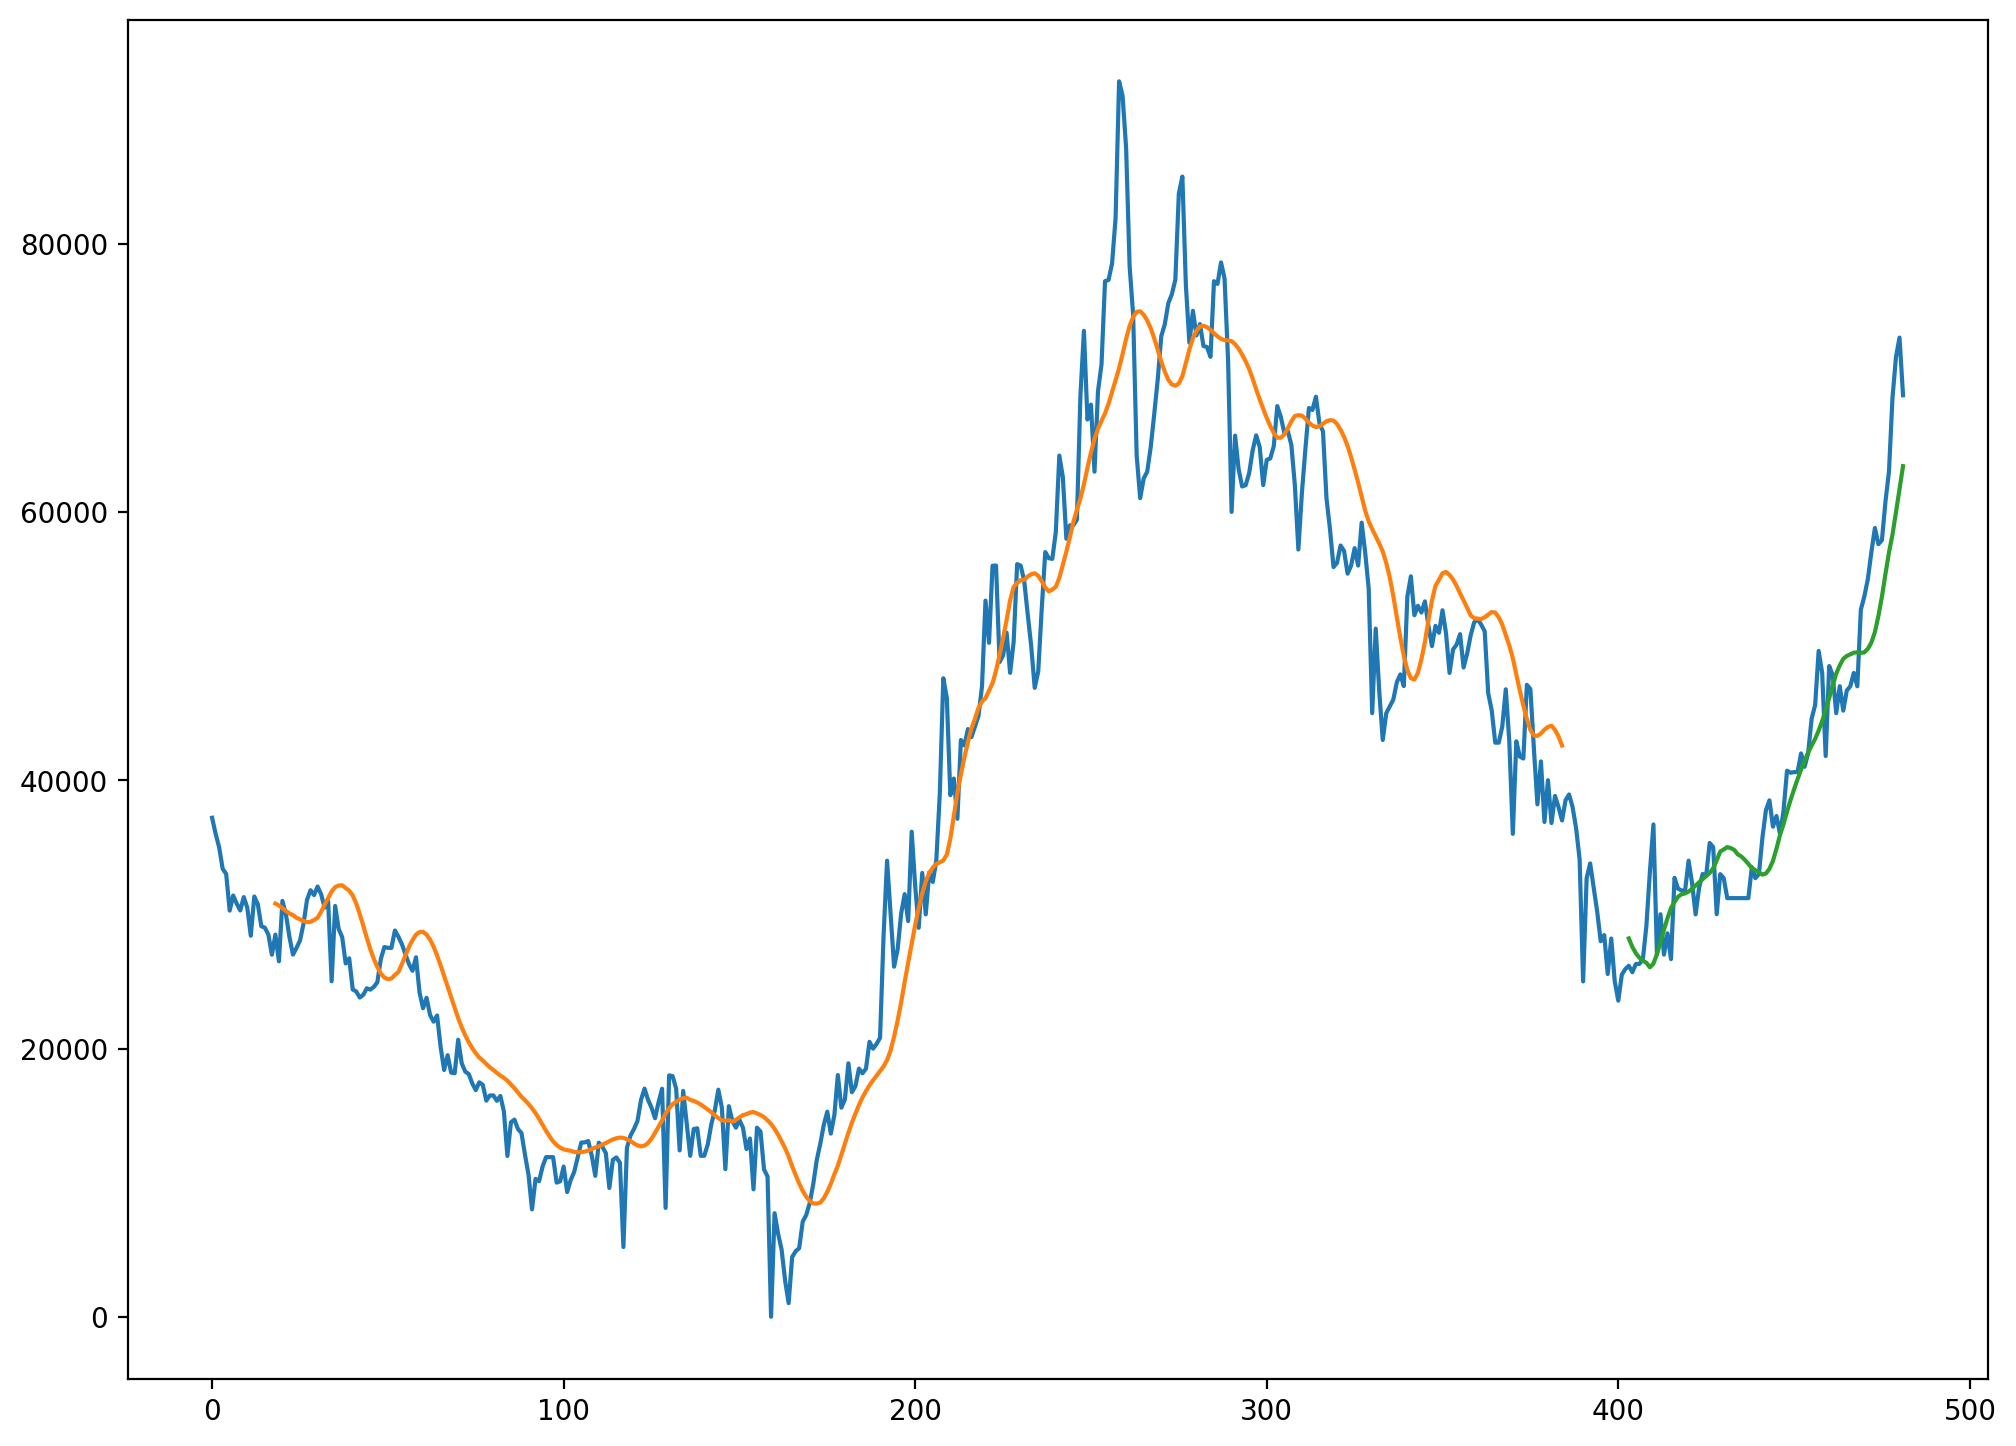

In [23]:
# Creating a plot for the predicted values
# Adding a time step to the plot as the first 18 values is used
time_step = 18

# Creating the prediction for train data
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict) + time_step, :] = train_predict

# Creating the prediction for test data
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (time_step * 2): len(df1), :] = test_predict

plt.figure(figsize=(12,9), dpi=200)
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [24]:
# Calculating the MSE
mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict)

15133745.459267767

The MSE of this LSTM model is performing much better compared to the baseline model.

In [26]:
# Creating the model to calculate success rate
def success_rate(actual_premium, predicted_premium):
    successful_bids = []
    if type(actual_premium) != np.ndarray:
        actual_reset = actual_premium.reset_index(drop=True)
        for i in range(len(predicted_premium)):
            if predicted_premium[i] >= actual_reset[i]:
                 successful_bids.append(actual_reset[i])
    else:
        for i in range(len(predicted_premium)):
            if predicted_premium[i] >= actual_premium[i]:
                 successful_bids.append(actual_premium[i])
    return round((len(successful_bids) / len(actual_premium)) * 100, 1), len(successful_bids), len(actual_premium)

In [27]:
# Calculating the success rate
success_rate(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict)

(40.5, 32, 79)

However, the success rate is only at 40.5%.

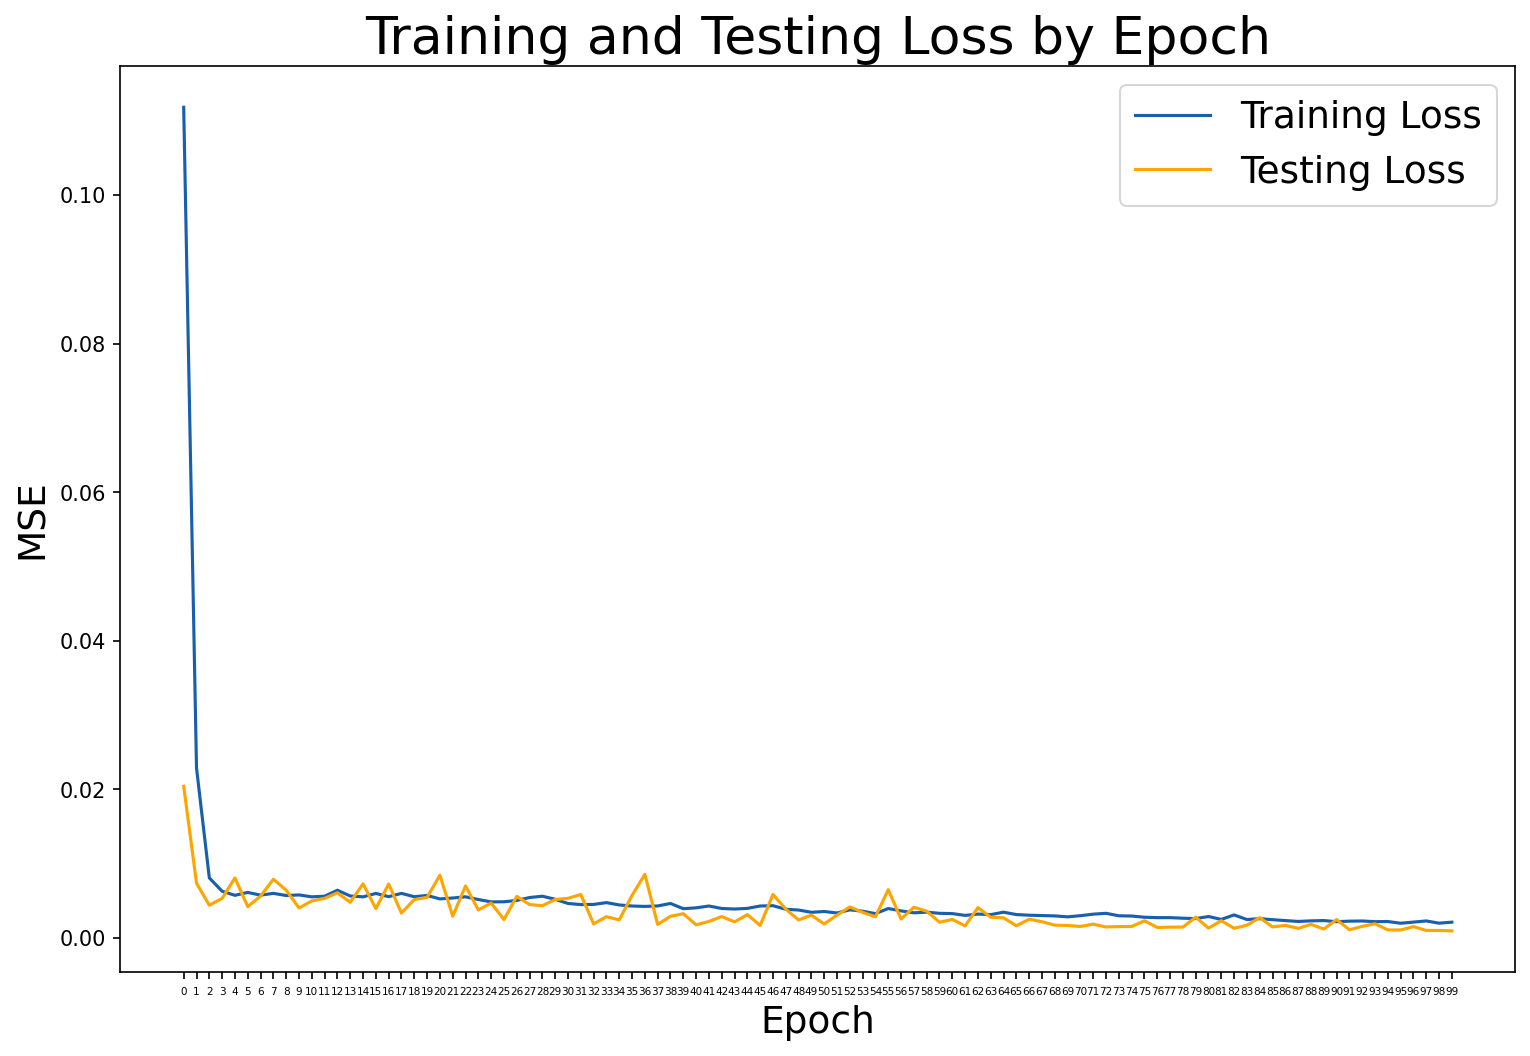

In [55]:
# Checking on the loss by epoch
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

plt.figure(figsize=(12, 8), dpi= 150)

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('MSE', fontsize=18)
plt.xticks(epoch_labels, epoch_labels, fontsize=5)    # ticks, labels

plt.legend(fontsize=18);

Looking at the training and testing loss by epoch, while the results seem to smoothen after about 62 epochs, it was taking too much time. Hence, I have chosen to run with only 50 epoch as it seems to be a good balance between time and overfitting. I then re-ran the above model with only 50 epoch.

In [230]:
summary_df = pd.read_csv('../data/summary_table.csv')

In [231]:
# Adding the model performance to the summary df
summary_df.loc[6] = ['RNN - LSTM',
                     'Univariate',
                     15133745.46,
                     40.5]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
0,ARIMA,Univariate,1.707664e+08,43.3
1,Linear Regression,Univariate,8.610584e+07,83.5
2,Linear Regression,Multivariate,6.277761e+08,100.0
3,Linear Regression w Lasso,Multivariate,6.291325e+08,100.0
4,Linear Regression w Ridge,Multivariate,6.291230e+08,100.0
5,SARIMA,Univariate,1.511497e+08,50.5
6,RNN - LSTM,Univariate,1.513375e+07,40.5


In [185]:
# Creating a df to store the predictions of the model
rnn_predict_df = pd.DataFrame(model_cat_a_rnn['premium'][-79:])

In [186]:
# Adding the predictions of the LSTM model
rnn_predict_df['LSTM_Prediction'] = test_predict
rnn_predict_df

,premium,LSTM_Prediction
new_date,,
2019-01-15,26170.0,28209.458984
2019-02-01,25689.0,27569.478516
2019-02-15,26301.0,27106.443359
2019-03-01,26309.0,26771.681641
2019-03-15,26659.0,26542.412109
...,...,...
2022-02-15,63000.0,56974.265625
2022-03-01,68501.0,58305.750000
2022-03-15,71556.0,59982.769531


### RNN model - GRU

Another model that is popular is the GRU model. Hence, I will be using GRU instead 

In [82]:
# Instantiating the model
model_gru = Sequential()
model_gru.add(GRU(
    16,
    input_shape=(18, 1),
    return_sequences=True,
))

model_gru.add(GRU(
    16,
    return_sequences=True,
))

model_gru.add(GRU(
    16,
    return_sequences=True,
))

model_gru.add(GRU(
    16,
    return_sequences=False,
))

model_gru.add(Dense(4, activation='relu'))
model_gru.add(Dense(1,))

In [83]:
# Compiling the model
model_gru.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [84]:
# Fitting the model
history_gru = model_gru.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=50
)

Train on 367 samples, validate on 79 samples
Epoch 1/50


2022-05-10 15:10:29.812036: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_gru_with_fallback_78256_78395' and '__inference___backward_standard_gru_80542_81101_specialized_for_StatefulPartitionedCall_2_at___inference_distributed_function_81859' both implement 'gru_18b3e221-94d3-4a3a-9f50-dfb58b648310' but their signatures do not match.


352/367 [===========================>..] - ETA: 0s - loss: 0.1846 - mae: 0.3558

2022-05-10 15:10:37.010208: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_gru_83345_specialized_for_sequential_4_gru_15_StatefulPartitionedCall_at___inference_distributed_function_83632' and '__inference_standard_gru_83345' both implement 'gru_f2b6fbe8-f6d2-475a-946f-ca8e124452e7' but their signatures do not match.


367/367 [==============================] - 12s 32ms/sample - loss: 0.1792 - mae: 0.3480 - val_loss: 0.0377 - val_mae: 0.1575
Epoch 2/50
367/367 [==============================] - 2s 4ms/sample - loss: 0.0352 - mae: 0.1602 - val_loss: 0.0090 - val_mae: 0.0696
Epoch 3/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0153 - mae: 0.1055 - val_loss: 0.0033 - val_mae: 0.0464
Epoch 4/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0040 - mae: 0.0474 - val_loss: 0.0022 - val_mae: 0.0351
Epoch 5/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0029 - mae: 0.0401 - val_loss: 0.0018 - val_mae: 0.0311
Epoch 6/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0028 - mae: 0.0385 - val_loss: 0.0019 - val_mae: 0.0322
Epoch 7/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0026 - mae: 0.0376 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 8/50
367/367 [==============================] - 2s 5ms/sample - l

In [85]:
# Getting the predicted train values
train_predict2 = model_gru.predict(X_train)
train_predict2 = scaler.inverse_transform(train_predict2)
train_predict2

2022-05-10 15:12:39.386185: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_gru_with_fallback_88435' and '__inference_standard_gru_88346_specialized_for_sequential_4_gru_12_StatefulPartitionedCall_at___inference_distributed_function_89811' both implement 'gru_a9cd7bc6-cd10-4cc2-96a8-ddb34b36e1eb' but their signatures do not match.


array([[29103.861 ],
       [29490.47  ],
       [28635.414 ],
       [30897.139 ],
       [31651.354 ],
       [30631.252 ],
       [29177.25  ],
       [28858.768 ],
       [29239.957 ],
       [30263.857 ],
       [31903.857 ],
       [33090.527 ],
       [33245.582 ],
       [33583.92  ],
       [33366.402 ],
       [32558.455 ],
       [32500.213 ],
       [28779.1   ],
       [30344.654 ],
       [30672.076 ],
       [30194.062 ],
       [28678.293 ],
       [28165.197 ],
       [26694.389 ],
       [25837.531 ],
       [25305.371 ],
       [25232.104 ],
       [25553.76  ],
       [25693.082 ],
       [25841.07  ],
       [26111.377 ],
       [27291.283 ],
       [28476.162 ],
       [28931.928 ],
       [29006.691 ],
       [29792.22  ],
       [29932.46  ],
       [29538.994 ],
       [28845.588 ],
       [28082.984 ],
       [27456.582 ],
       [27824.912 ],
       [26550.05  ],
       [25052.996 ],
       [24844.934 ],
       [24210.188 ],
       [23556.906 ],
       [23527

In [86]:
# Getting the predicted test values
test_predict2 = model_gru.predict(X_test)
test_predict2 = scaler.inverse_transform(test_predict2)
test_predict2

array([[26900.83 ],
       [27400.701],
       [27281.145],
       [27505.58 ],
       [27665.11 ],
       [27930.49 ],
       [29593.922],
       [33056.527],
       [37000.67 ],
       [32099.188],
       [31116.441],
       [29408.158],
       [29603.326],
       [28758.316],
       [32052.78 ],
       [33477.918],
       [33637.39 ],
       [33522.703],
       [34927.934],
       [34530.67 ],
       [32630.99 ],
       [33048.316],
       [34184.527],
       [34610.03 ],
       [36288.727],
       [36854.23 ],
       [33561.547],
       [33887.34 ],
       [34294.21 ],
       [33452.402],
       [32980.742],
       [32860.547],
       [32858.383],
       [32869.89 ],
       [32874.58 ],
       [32874.71 ],
       [34384.758],
       [34609.754],
       [34713.39 ],
       [36553.855],
       [38844.594],
       [40197.28 ],
       [39159.227],
       [39100.59 ],
       [38274.184],
       [39087.56 ],
       [41675.727],
       [42608.996],
       [42744.324],
       [42701.18 ],


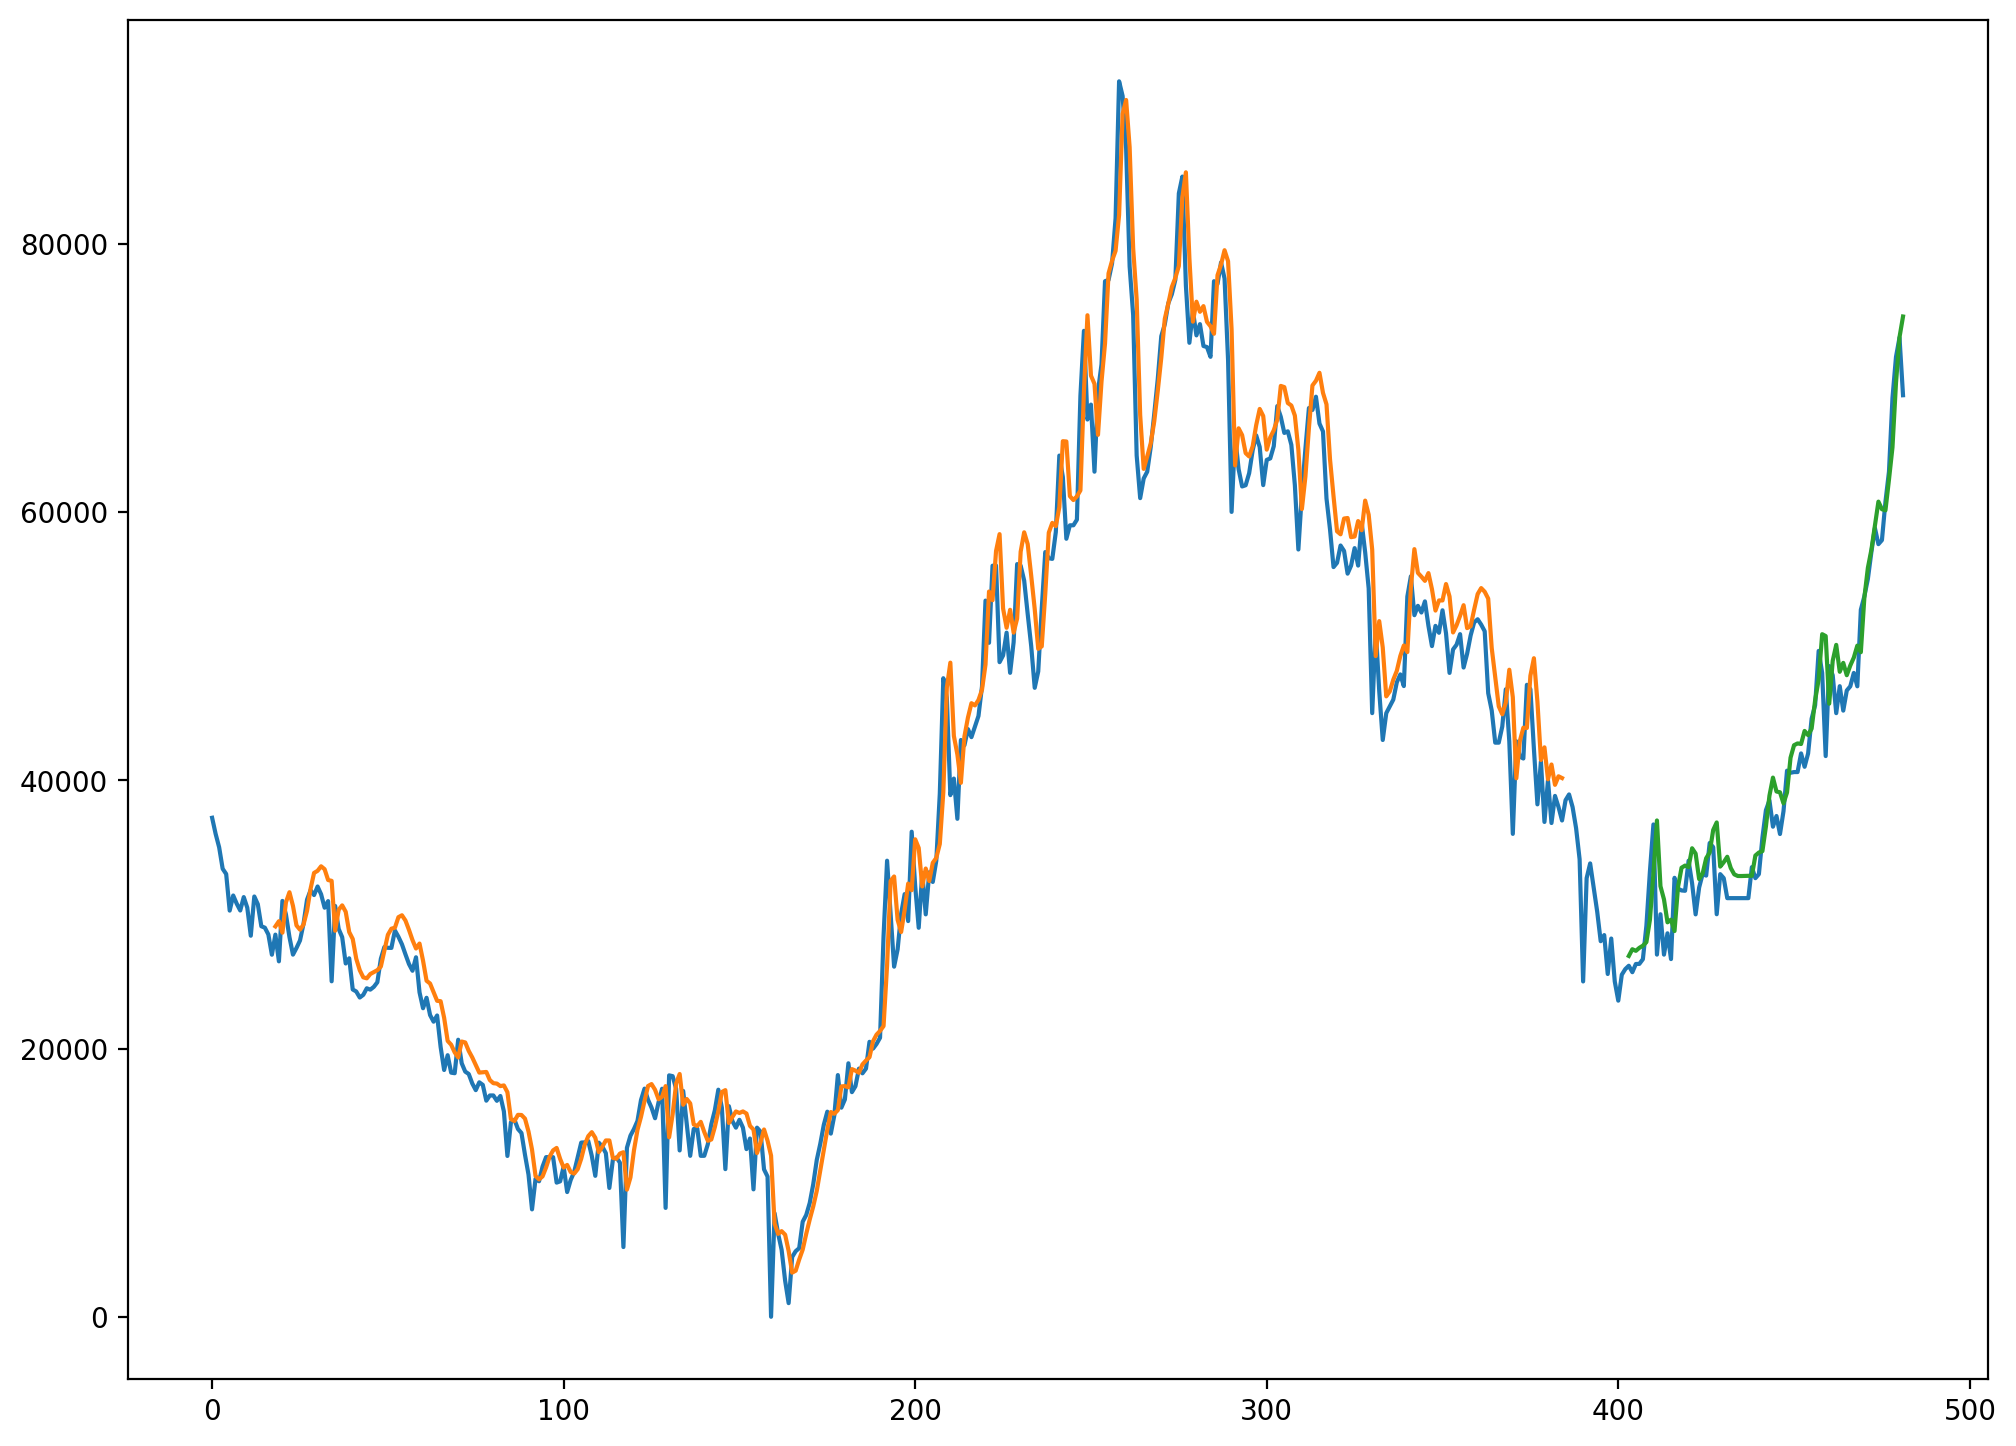

In [87]:
# Creating a plot for the predicted values
time_step = 18
trainPredictPlot2 = np.empty_like(df1)
trainPredictPlot2[:, :] = np.nan
trainPredictPlot2[time_step:len(train_predict2) + time_step, :] = train_predict2

testPredictPlot2 = np.empty_like(df1)
testPredictPlot2[:, :] = np.nan
testPredictPlot2[len(train_predict2) + (time_step * 2): len(df1), :] = test_predict2

plt.figure(figsize=(12,9), dpi=200)
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot2)
plt.plot(testPredictPlot2)
plt.show()

In [88]:
# Calculating the MSE
mean_squared_error(model_cat_a_rnn['premium'][-79:], test_predict2)

7453959.025294823

The model improved even further compare to the LSTM model.

In [89]:
# Checking the model summary
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 18, 16)            912       
_________________________________________________________________
gru_13 (GRU)                 (None, 18, 16)            1632      
_________________________________________________________________
gru_14 (GRU)                 (None, 18, 16)            1632      
_________________________________________________________________
gru_15 (GRU)                 (None, 16)                1632      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 5,881
Trainable params: 5,881
Non-trainable params: 0
____________________________________________________

In [90]:
# Calculating the success rate
success_rate(model_cat_a_rnn['premium'][-79:], test_predict2)

(75.9, 60, 79)

The success rate had also improved compared to the LSTM model.

In [232]:
# Adding the model performance to the summary df
summary_df.loc[7] = ['RNN - GRU',
                     'Univariate',
                     7453959.03,
                     75.9]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
0,ARIMA,Univariate,1.707664e+08,43.3
1,Linear Regression,Univariate,8.610584e+07,83.5
2,Linear Regression,Multivariate,6.277761e+08,100.0
3,Linear Regression w Lasso,Multivariate,6.291325e+08,100.0
4,Linear Regression w Ridge,Multivariate,6.291230e+08,100.0
5,SARIMA,Univariate,1.511497e+08,50.5
6,RNN - LSTM,Univariate,1.513375e+07,40.5
7,RNN - GRU,Univariate,7.453959e+06,75.9


In [187]:
# Adding the predictions of the GRU model
rnn_predict_df['GRU_Predictions'] = test_predict2
rnn_predict_df

,premium,LSTM_Prediction,GRU_Predictions
new_date,,,
2019-01-15,26170.0,28209.458984,26900.830078
2019-02-01,25689.0,27569.478516,27400.701172
2019-02-15,26301.0,27106.443359,27281.144531
2019-03-01,26309.0,26771.681641,27505.580078
2019-03-15,26659.0,26542.412109,27665.109375
...,...,...,...
2022-02-15,63000.0,56974.265625,62398.953125
2022-03-01,68501.0,58305.750000,64817.832031
2022-03-15,71556.0,59982.769531,69614.687500


## RNN GRU model - Multivariate

Next I attempted to use the GRU model and added more variables to see if the RNN is able to handle it better than the regression models.

In [130]:
model_cat_a_rnn_lag

,bidding_exercise,date_x,year,category,premium,quota,total_bids_received,number_of_successful_bids,quarter,month,...,average_income,median_income,average_employed_income,median_employed_income,close,day_lag,month_lag,air_departures,crude_birth_rate_per_thousand_residents,scarcity
new_date,,,,,,,,,,,,,,,,,,,,,
2002-04-01,April 2002 First Open Bidding Exercise,2002-04-01 00:00:00,2002,cat_a,37201.0,1110.0,2484.0,1092.0,2,4,...,5338.0,3860.0,5736.0,4141.0,1813.177000,1,4,1184705.0,11.8,0.446860
2002-04-15,April 2002 Second Open Bidding Exercise,2002-04-15 00:00:00,2002,cat_a,36000.0,1149.0,1890.0,1148.0,2,4,...,5338.0,3860.0,5736.0,4141.0,1799.878000,15,4,1184705.0,11.8,0.607937
2002-05-01,May 2002 First Open Bidding Exercise,2002-05-01 00:00:00,2002,cat_a,35000.0,1128.0,1705.0,1127.0,2,5,...,5338.0,3860.0,5736.0,4141.0,1742.603333,1,5,1101439.0,11.8,0.661584
2002-05-15,May 2002 Second Open Bidding Exercise,2002-05-15 00:00:00,2002,cat_a,33401.0,1111.0,1320.0,1080.0,2,5,...,5338.0,3860.0,5736.0,4141.0,1776.763000,15,5,1101439.0,11.8,0.841667
2002-06-01,June 2002 First Open Bidding Exercise,2002-06-01 00:00:00,2002,cat_a,33009.0,1111.0,1382.0,1105.0,2,6,...,5338.0,3860.0,5736.0,4141.0,1713.361667,1,6,1155074.0,11.8,0.803907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,February 2022 Second Open Bidding Exercise,2022-02-23 00:00:00,2022,cat_a,63000.0,536.0,876.0,524.0,1,2,...,9827.0,7261.0,11137.0,8421.0,3213.605000,15,2,323007.0,8.6,0.611872
2022-03-01,March 2022 First Open Bidding Exercise,2022-03-09 00:00:00,2022,cat_a,68501.0,531.0,962.0,526.0,1,3,...,9827.0,7261.0,11137.0,8421.0,3377.386000,1,3,334406.0,8.6,0.551975
2022-03-15,March 2022 Second Open Bidding Exercise,2022-03-23 00:00:00,2022,cat_a,71556.0,543.0,849.0,542.0,1,3,...,9827.0,7261.0,11137.0,8421.0,3389.226250,15,3,334406.0,8.6,0.639576


In [216]:
# Creating the scarcity feature
model_cat_a_rnn_lag['scarcity'] = model_cat_a_rnn_lag['quota'] / model_cat_a_rnn_lag['total_bids_received']

In [132]:
# Creating the df to use for the multivariate model
df2 = model_cat_a_rnn_lag[[
    'premium', 'scarcity'
]]

In [133]:
# Scaling the data
scaler2 = MinMaxScaler()
df2 = scaler2.fit_transform(df2)

In [134]:
# Performing Manual train test split
training_size = int(len(df2)*0.8)
test_size = len(df2) - training_size
multi_train, multi_test = df2[0:training_size], df2[training_size:len(df2)]

In [135]:
# Creating a function to create X and y with timsteps and multiple variables
def prepare_train_data_multi(n_train_data, n_dim, time_steps):
    print('Initial shape of Input',n_train_data.shape)
    X = []
    y = []
    for i in range(len(n_train_data)-time_steps):
        t=[]
        for j in range(0,time_steps):        
            t.append(n_train_data[[(i+j)], :])
        X.append(t)
        y.append(n_train_data[i+ time_steps,0])

    X, y = np.array(X), np.array(y)
    print('Shape of X after transformation',X.shape)
    print('Shape of y after transformation ',y.shape)

    X = X.reshape(X.shape[0],time_steps, n_dim)
    print('Final X_train Shape ',X.shape)
    return X,y

In [136]:
# Creating the X train and y train with 2 variables and 18 time steps
X_train_multi, y_train_multi = prepare_train_data_multi(multi_train, 2, 18)

Initial shape of Input (385, 2)
Shape of X after transformation (367, 18, 1, 2)
Shape of y after transformation  (367,)
Final X_train Shape  (367, 18, 2)


In [137]:
X_train_multi

array([[[0.40390671, 0.2268237 ],
        [0.39086625, 0.45219573],
        [0.38000825, 0.52725659],
        ...,
        [0.31494712, 0.56270729],
        [0.30944212, 0.6084463 ],
        [0.29306825, 0.81251138]],

       [[0.39086625, 0.45219573],
        [0.38000825, 0.52725659],
        [0.36264631, 0.77922174],
        ...,
        [0.30944212, 0.6084463 ],
        [0.29306825, 0.81251138],
        [0.30931182, 0.47371453]],

       [[0.38000825, 0.52725659],
        [0.36264631, 0.77922174],
        [0.35838998, 0.72639044],
        ...,
        [0.29306825, 0.81251138],
        [0.30931182, 0.47371453],
        [0.2877044 , 0.73126243]],

       ...,

       [[0.4907707 , 0.78449326],
        [0.4647115 , 0.76006584],
        [0.4647115 , 0.76187442],
        ...,
        [0.40052987, 0.83831425],
        [0.43429825, 0.51347983],
        [0.39966123, 0.65585871]],

       [[0.4647115 , 0.76006584],
        [0.4647115 , 0.76187442],
        [0.47775196, 0.71846358],
        .

In [138]:
X_train_multi

array([[[0.40390671, 0.2268237 ],
        [0.39086625, 0.45219573],
        [0.38000825, 0.52725659],
        ...,
        [0.31494712, 0.56270729],
        [0.30944212, 0.6084463 ],
        [0.29306825, 0.81251138]],

       [[0.39086625, 0.45219573],
        [0.38000825, 0.52725659],
        [0.36264631, 0.77922174],
        ...,
        [0.30944212, 0.6084463 ],
        [0.29306825, 0.81251138],
        [0.30931182, 0.47371453]],

       [[0.38000825, 0.52725659],
        [0.36264631, 0.77922174],
        [0.35838998, 0.72639044],
        ...,
        [0.29306825, 0.81251138],
        [0.30931182, 0.47371453],
        [0.2877044 , 0.73126243]],

       ...,

       [[0.4907707 , 0.78449326],
        [0.4647115 , 0.76006584],
        [0.4647115 , 0.76187442],
        ...,
        [0.40052987, 0.83831425],
        [0.43429825, 0.51347983],
        [0.39966123, 0.65585871]],

       [[0.4647115 , 0.76006584],
        [0.4647115 , 0.76187442],
        [0.47775196, 0.71846358],
        .

In [159]:
# Instantiating the model
model_multi = Sequential()
model_multi.add(GRU(
    16,
    input_shape=(18, 2),
    return_sequences=True,
))

model_multi.add(GRU(
    16,
    return_sequences=True,
))

model_multi.add(GRU(
    16,
    return_sequences=True,
))

model_multi.add(GRU(
    16,
    return_sequences=False,
))


model_multi.add(Dense(4, activation='relu'))
model_multi.add(Dense(1,))

# Compiling the model
model_multi.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fitting the model
history_multi = model_multi.fit(
    X_train_multi,
    y_train_multi,
    batch_size=16,
    epochs=50
)

Train on 367 samples
Epoch 1/50


2022-05-10 15:25:35.611319: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_gru_164043_164602_specialized_for_StatefulPartitionedCall_2_at___inference_distributed_function_165360' and '__inference___backward_cudnn_gru_with_fallback_161757_161896' both implement 'gru_88378cab-e80e-4021-b7c0-2a1e92c9e7e2' but their signatures do not match.


367/367 [==============================] - 11s 29ms/sample - loss: 0.0738 - mae: 0.2148
Epoch 2/50
367/367 [==============================] - 2s 6ms/sample - loss: 0.0122 - mae: 0.0843
Epoch 3/50
367/367 [==============================] - 3s 9ms/sample - loss: 0.0042 - mae: 0.0496
Epoch 4/50
367/367 [==============================] - 4s 10ms/sample - loss: 0.0033 - mae: 0.0420
Epoch 5/50
367/367 [==============================] - 3s 7ms/sample - loss: 0.0033 - mae: 0.0428
Epoch 6/50
367/367 [==============================] - 3s 9ms/sample - loss: 0.0031 - mae: 0.0404
Epoch 7/50
367/367 [==============================] - 3s 8ms/sample - loss: 0.0031 - mae: 0.0411
Epoch 8/50
367/367 [==============================] - 3s 8ms/sample - loss: 0.0027 - mae: 0.0373
Epoch 9/50
367/367 [==============================] - 4s 11ms/sample - loss: 0.0028 - mae: 0.0386
Epoch 10/50
367/367 [==============================] - 6s 16ms/sample - loss: 0.0027 - mae: 0.0360
Epoch 11/50
367/367 [==============

In [160]:
# Creating the X test and y test with 2 variables and 18 time steps
X_test_multi, y_test_multi = prepare_train_data_multi(multi_test, 2, 18)

Initial shape of Input (97, 2)
Shape of X after transformation (79, 18, 1, 2)
Shape of y after transformation  (79,)
Final X_train Shape  (79, 18, 2)


In [161]:
# Creating a function to reshape and predict the test data using the model
def predict_data(model_name, scaler_pred, test_data, X_test, n_dim):
    pred = model_name.predict(X_test)
    dummy_dataset = np.zeros(shape=(len(pred), n_dim))
    dummy_dataset[:,0] = pred[:,0]
    dummy_dataset = scaler_pred.inverse_transform(dummy_dataset)[:,0]
    pred_df = pd.DataFrame(dummy_dataset,columns=['Predicted'])
    return pred_df

In [162]:
# Creating a df with the test prediction
prediction_df = predict_data(model_multi, scaler2, multi_test, X_test_multi, 2)
prediction_df

2022-05-10 15:29:36.005765: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_gru_169962_specialized_for_sequential_9_gru_34_StatefulPartitionedCall_at___inference_distributed_function_170613' and '__inference_cudnn_gru_with_fallback_170051' both implement 'gru_27e27b57-821d-4cc3-a19e-16871da66761' but their signatures do not match.


,Predicted
0,25025.610750
1,25585.089153
2,25295.396172
3,25378.877266
4,25548.449695
...,...
74,58574.948079
75,60930.830371
76,65041.327971
77,68108.217211


In [164]:
# Setting the index of the predictions to be the same index as the actual values
prediction_df['index'] = model_cat_a_rnn[-79:].index
prediction_df.set_index('index', inplace=True)

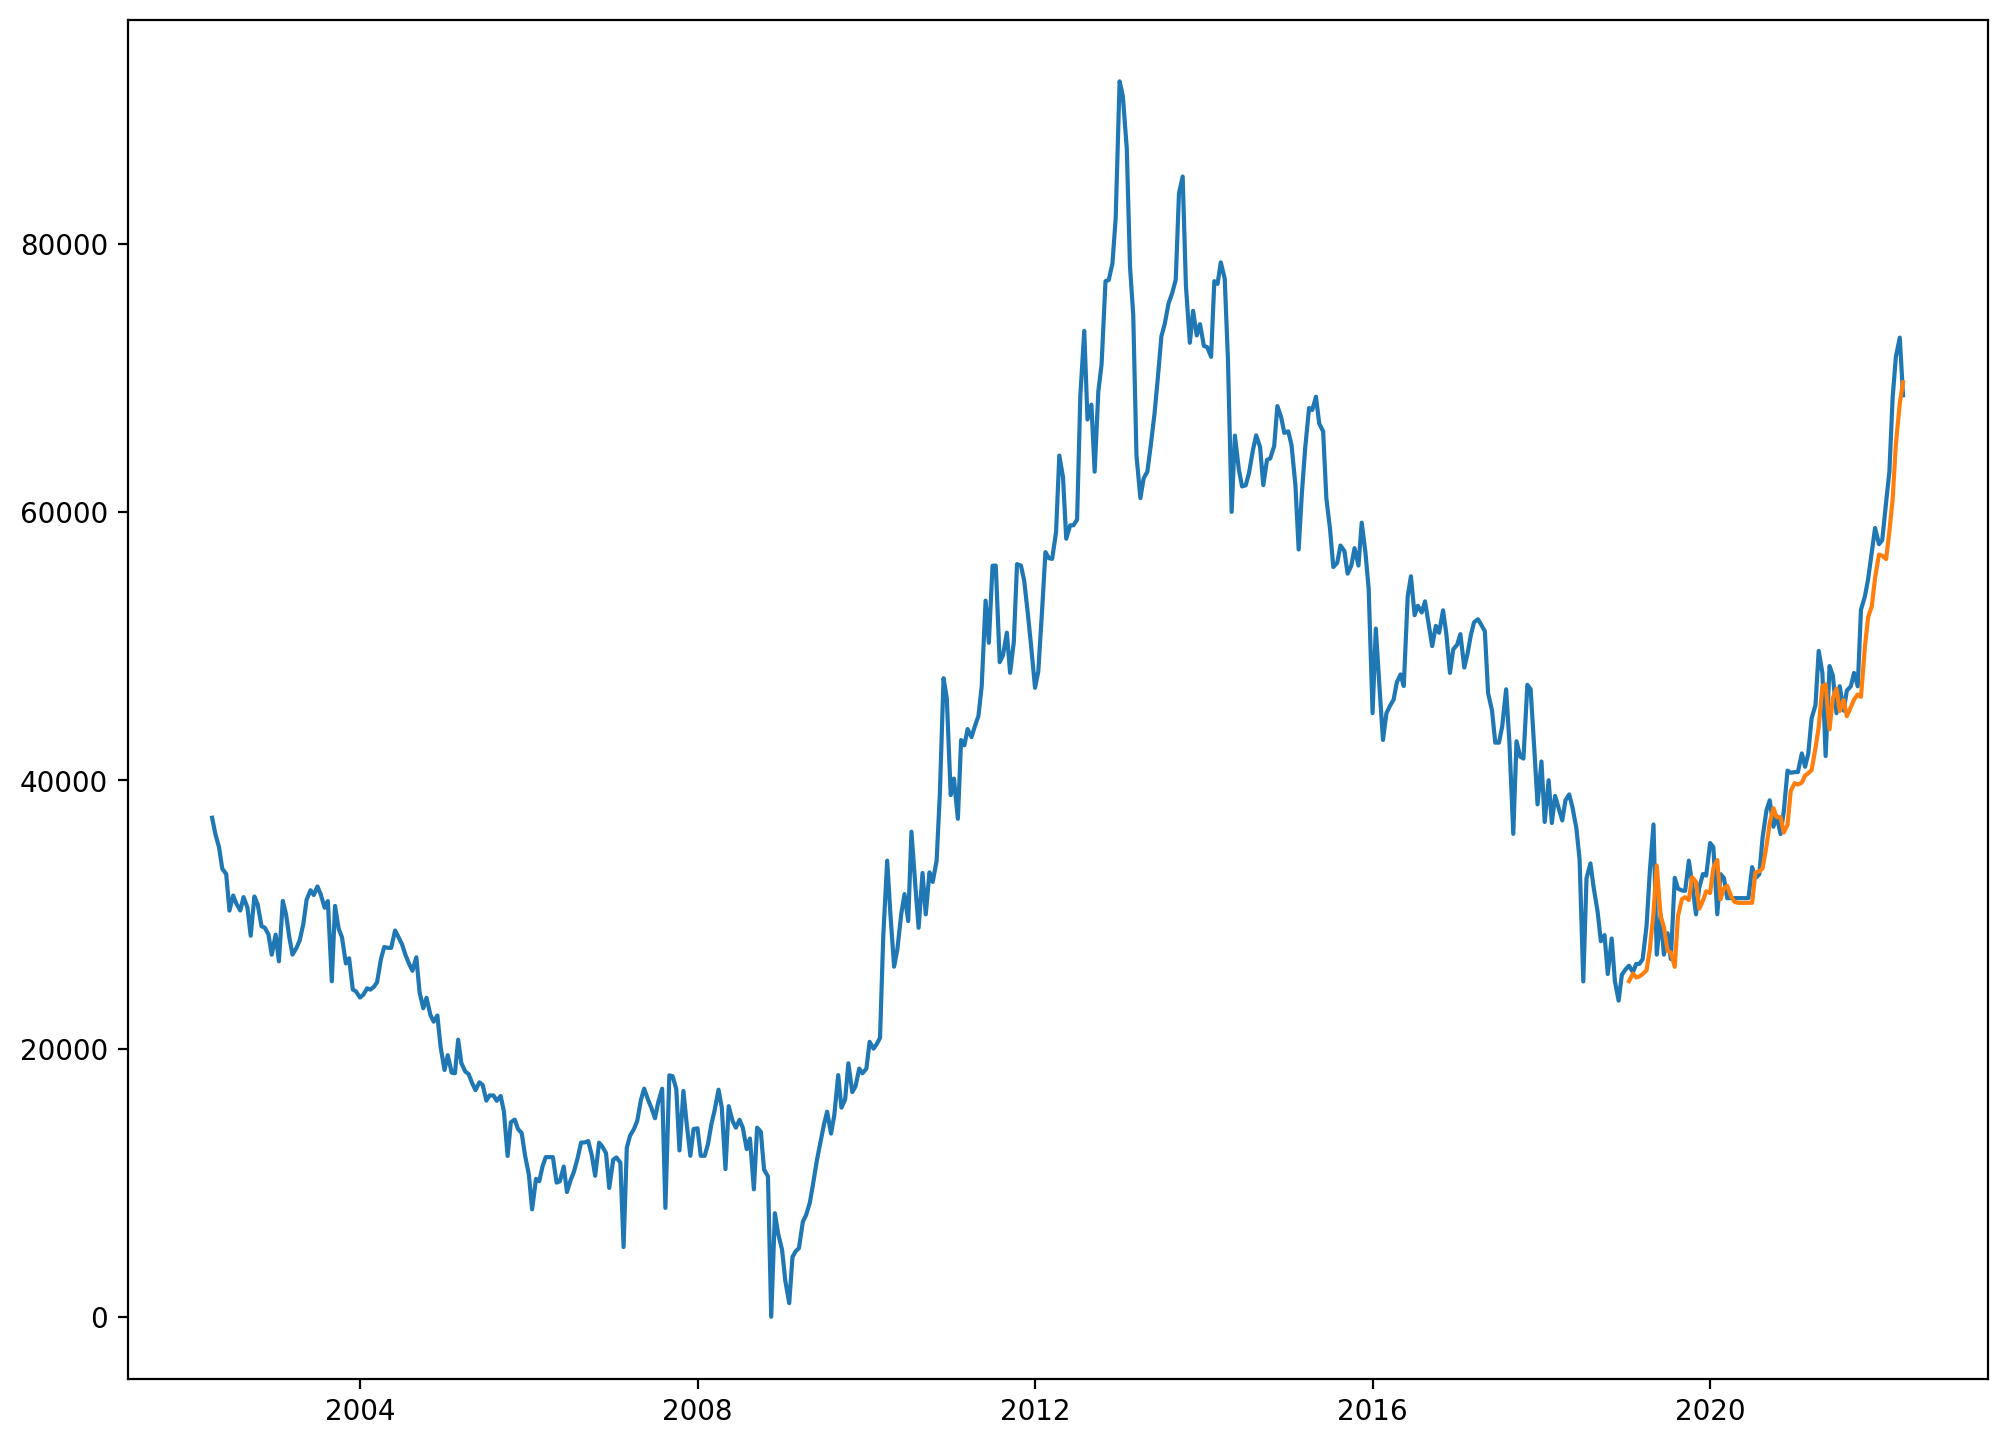

In [166]:
# Creating a plot for the predicted values
plt.figure(figsize=(12,9), dpi = 200)
plt.plot(model_cat_a_rnn['premium'])
plt.plot(prediction_df);

In [167]:
# Calculating the MSE
mean_squared_error(model_cat_a_rnn['premium'][-79:], prediction_df['Predicted'])

8823055.688524546

In [168]:
# Calculating the success rate
success_rate(model_cat_a_rnn['premium'][-79:], prediction_df['Predicted'])

(20.3, 16, 79)

The MSE and success rate of the model actually performed slightly worse compared to the univariate GRU model.

In [188]:
# Adding the predictions of the multivariate GRU model
prediction_df['date'] = rnn_predict_df.index
prediction_df.set_index('date', inplace=True)
rnn_predict_df['GRU_Multi_Predictions'] = prediction_df
rnn_predict_df

,premium,LSTM_Prediction,GRU_Predictions,GRU_Multi_Predictions
new_date,,,,
2019-01-15,26170.0,28209.458984,26900.830078,25025.610750
2019-02-01,25689.0,27569.478516,27400.701172,25585.089153
2019-02-15,26301.0,27106.443359,27281.144531,25295.396172
2019-03-01,26309.0,26771.681641,27505.580078,25378.877266
2019-03-15,26659.0,26542.412109,27665.109375,25548.449695
...,...,...,...,...
2022-02-15,63000.0,56974.265625,62398.953125,58574.948079
2022-03-01,68501.0,58305.750000,64817.832031,60930.830371
2022-03-15,71556.0,59982.769531,69614.687500,65041.327971


In [233]:
# Adding the model performance to the summary df
summary_df.loc[8] = ['RNN - GRU 1',
                     'Multivariate',
                     8823055.69,
                     20.3]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
0,ARIMA,Univariate,1.707664e+08,43.3
1,Linear Regression,Univariate,8.610584e+07,83.5
2,Linear Regression,Multivariate,6.277761e+08,100.0
3,Linear Regression w Lasso,Multivariate,6.291325e+08,100.0
4,Linear Regression w Ridge,Multivariate,6.291230e+08,100.0
5,SARIMA,Univariate,1.511497e+08,50.5
6,RNN - LSTM,Univariate,1.513375e+07,40.5
7,RNN - GRU,Univariate,7.453959e+06,75.9
8,RNN - GRU 1,Multivariate,8.823056e+06,20.3


## Multivariate GRU model 2

I will attempt to see if adding even more variables will improve the model. The variables I chose here are the same variables as the ones used in the previous linear regression model.

In [114]:
model_cat_a_rnn_lag.columns

Index(['bidding_exercise', 'date_x', 'year', 'category', 'premium', 'quota',
       'total_bids_received', 'number_of_successful_bids', 'quarter', 'month',
       'day', 'total_motor_veh', 'cat_a', 'month_lag_x', 'year_lag_x',
       'total_motor_veh_dereg', 'cat_a_dereg', 'date_y', 'month_lag_y',
       'year_lag_y', 'gdp_at_current_market_prices', 'year_lag', 'quarter_lag',
       'year_lag2', 'quarter_lag2', 'total_pop', 'pop_density',
       'total_pop_growth', 'average_income', 'median_income',
       'average_employed_income', 'median_employed_income', 'close', 'day_lag',
       'month_lag', 'air_departures',
       'crude_birth_rate_per_thousand_residents', 'scarcity'],
      dtype='object')

In [115]:
# Creating a new df with the chosen variables
df3 = model_cat_a_rnn_lag[[
    'premium', 'quota', 'cat_a_dereg', 'total_pop_growth', 'close'
]]

In [116]:
# Scaling the data
scaler3 = MinMaxScaler()
df3 = scaler3.fit_transform(df3)


In [117]:
# Performing Manual train test split
training_size = int(len(df3)*0.8)
test_size = len(df3) - training_size
multi_train3, multi_test3 = df3[0:training_size], df3[training_size:len(df3)]

In [118]:
# Creating X and y for training data with 5 variables and 18 timsteps
X_train_multi3, y_train_multi3 = prepare_train_data_multi(multi_train3, 5, 18)

Initial shape of Input (385, 5)
Shape of X after transformation (367, 18, 1, 5)
Shape of y after transformation  (367,)
Final X_train Shape  (367, 18, 5)


In [119]:
# Instantiating the model
model_multi2 = Sequential()
model_multi2.add(GRU(
    16,
    input_shape=(18, 5),
    return_sequences=True,
))

model_multi2.add(GRU(
    16,
    return_sequences=True,
))

model_multi2.add(GRU(
    16,
    return_sequences=True,
))

model_multi2.add(GRU(
    16,
    return_sequences=False,
))

model_multi2.add(Dense(4, activation='relu'))
model_multi2.add(Dense(1,))

# Compiling the model
model_multi2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fitting the model
history_multi2 = model_multi2.fit(
    X_train_multi3,
    y_train_multi3,
    batch_size=16,
    epochs=50
)

Train on 367 samples
Epoch 1/50


2022-05-10 15:17:16.856202: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_gru_with_fallback_113316_113455' and '__inference___backward_standard_gru_115602_116161_specialized_for_StatefulPartitionedCall_2_at___inference_distributed_function_116919' both implement 'gru_6601ef9c-440b-4261-b996-26cb107dee81' but their signatures do not match.


367/367 [==============================] - 10s 28ms/sample - loss: 0.0192 - mae: 0.1010
Epoch 2/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0047 - mae: 0.0537
Epoch 3/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0038 - mae: 0.0463
Epoch 4/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0029 - mae: 0.0391
Epoch 5/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0027 - mae: 0.0384
Epoch 6/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0028 - mae: 0.0386
Epoch 7/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0025 - mae: 0.0375
Epoch 8/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0025 - mae: 0.0360
Epoch 9/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0024 - mae: 0.0360
Epoch 10/50
367/367 [==============================] - 2s 5ms/sample - loss: 0.0023 - mae: 0.0352
Epoch 11/50
367/367 [=================

In [120]:
# Creating X and y for test data with 5 variables and 18 timsteps
X_test_multi3, y_test_multi3 = prepare_train_data_multi(multi_test3, 5, 18)

Initial shape of Input (97, 5)
Shape of X after transformation (79, 18, 1, 5)
Shape of y after transformation  (79,)
Final X_train Shape  (79, 18, 5)


In [121]:
# Getting the predicted test values
prediction_df2 = predict_data(model_multi2, scaler3, multi_test3, X_test_multi3, 5)
prediction_df2

2022-05-10 15:19:18.330468: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_gru_120707' and '__inference_standard_gru_120707_specialized_for_sequential_6_gru_20_StatefulPartitionedCall_at___inference_distributed_function_122172' both implement 'gru_8206e779-a168-41d2-ba0e-0c095a472129' but their signatures do not match.


,Predicted
0,22962.083831
1,23203.277357
2,22835.124774
3,22862.297644
4,23181.739427
...,...
74,55427.325225
75,57856.387622
76,62018.650911
77,64938.696866


In [123]:
# Calculating the MSE
mean_squared_error(model_cat_a_rnn['premium'][-79:], prediction_df2['Predicted'])

19145021.117766667

In [124]:
# Calculating the success rate
success_rate(model_cat_a_rnn['premium'][-79:], prediction_df2['Predicted'])

(5.1, 4, 79)

In [189]:
# Adding the predictions of the 2nd Multivariate GRU model
prediction_df2['date'] = rnn_predict_df.index
prediction_df2.set_index('date', inplace=True)
rnn_predict_df['GRU_Multi2_Predictions'] = prediction_df2
rnn_predict_df

,premium,LSTM_Prediction,GRU_Predictions,GRU_Multi_Predictions,GRU_Multi2_Predictions
new_date,,,,,
2019-01-15,26170.0,28209.458984,26900.830078,25025.610750,22962.083831
2019-02-01,25689.0,27569.478516,27400.701172,25585.089153,23203.277357
2019-02-15,26301.0,27106.443359,27281.144531,25295.396172,22835.124774
2019-03-01,26309.0,26771.681641,27505.580078,25378.877266,22862.297644
2019-03-15,26659.0,26542.412109,27665.109375,25548.449695,23181.739427
...,...,...,...,...,...
2022-02-15,63000.0,56974.265625,62398.953125,58574.948079,55427.325225
2022-03-01,68501.0,58305.750000,64817.832031,60930.830371,57856.387622
2022-03-15,71556.0,59982.769531,69614.687500,65041.327971,62018.650911


In [234]:
# Adding the model performance to the summary df
summary_df.loc[9] = ['RNN - GRU 2',
                     'Multivariate',
                     19145021.11,
                     5.1]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
0,ARIMA,Univariate,1.707664e+08,43.3
1,Linear Regression,Univariate,8.610584e+07,83.5
2,Linear Regression,Multivariate,6.277761e+08,100.0
3,Linear Regression w Lasso,Multivariate,6.291325e+08,100.0
4,Linear Regression w Ridge,Multivariate,6.291230e+08,100.0
5,SARIMA,Univariate,1.511497e+08,50.5
6,RNN - LSTM,Univariate,1.513375e+07,40.5
7,RNN - GRU,Univariate,7.453959e+06,75.9
8,RNN - GRU 1,Multivariate,8.823056e+06,20.3
9,RNN - GRU 2,Multivariate,1.914502e+07,5.1


## Multivariate GRU model 3

As mentioned in the previous notebooks, one reason why other variables may not be a good predictor of the premium is due to the resolution of the data. Hence, with this model, I want to try to use datasets with very high resolution.

In [311]:
# Creating a df with chosen variable
df4 = model_cat_a_rnn_lag[[
    'premium', 'scarcity', 'close'
]]

In [312]:
# Scaling the data
scaler4 = MinMaxScaler()
df4 = scaler4.fit_transform(df4)


In [313]:
# Performing Manual train test split
training_size = int(len(df4)*0.8)
test_size = len(df4) - training_size
multi_train4, multi_test4 = df4[0:training_size], df4[training_size:len(df4)]

In [314]:
# Creating X and y for training data with 3 variables and 18 timsteps
X_train_multi4, y_train_multi4 = prepare_train_data_multi(multi_train4, 3, 18)

Initial shape of Input (385, 3)
Shape of X after transformation (367, 18, 1, 3)
Shape of y after transformation  (367,)
Final X_train Shape  (367, 18, 3)


In [315]:
# Instantiating the model
model_multi3 = Sequential()
model_multi3.add(GRU(
    16,
    input_shape=(18, 3),
    return_sequences=True,
))

model_multi3.add(GRU(
    16,
    return_sequences=True,
))

model_multi3.add(GRU(
    16,
    return_sequences=True,
))

model_multi3.add(GRU(
    16,
    return_sequences=False,
))

model_multi3.add(Dense(4, activation='relu'))
model_multi3.add(Dense(1,))

# Compiling the model
model_multi3.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fitting the model
history_multi3 = model_multi3.fit(
    X_train_multi4,
    y_train_multi4,
    batch_size=16,
    epochs=50
)

Train on 367 samples
Epoch 1/50


2022-05-11 14:25:59.290582: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_gru_with_fallback_307894_308033' and '__inference___backward_standard_gru_308154_308713_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_310683' both implement 'gru_d5482843-36ee-455f-8393-1fa167b871b3' but their signatures do not match.


367/367 [==============================] - 11s 29ms/sample - loss: 0.0825 - mae: 0.2261
Epoch 2/50
367/367 [==============================] - 3s 7ms/sample - loss: 0.0198 - mae: 0.1118
Epoch 3/50
367/367 [==============================] - 2s 6ms/sample - loss: 0.0056 - mae: 0.0569
Epoch 4/50
367/367 [==============================] - 2s 6ms/sample - loss: 0.0035 - mae: 0.0420
Epoch 5/50
367/367 [==============================] - 3s 8ms/sample - loss: 0.0032 - mae: 0.0404
Epoch 6/50
367/367 [==============================] - 3s 8ms/sample - loss: 0.0030 - mae: 0.0392
Epoch 7/50
367/367 [==============================] - 4s 10ms/sample - loss: 0.0033 - mae: 0.0423
Epoch 8/50
367/367 [==============================] - 2s 6ms/sample - loss: 0.0031 - mae: 0.0398
Epoch 9/50
367/367 [==============================] - 3s 7ms/sample - loss: 0.0030 - mae: 0.0396
Epoch 10/50
367/367 [==============================] - 5s 12ms/sample - loss: 0.0028 - mae: 0.0376
Epoch 11/50
367/367 [===============

In [316]:
# Creating X and y for test data with 3 variables and 18 timsteps
X_test_multi4, y_test_multi4 = prepare_train_data_multi(multi_test4, 3, 18)

Initial shape of Input (97, 3)
Shape of X after transformation (79, 18, 1, 3)
Shape of y after transformation  (79,)
Final X_train Shape  (79, 18, 3)


In [317]:
# Getting the predicted test values
prediction_df3 = predict_data(model_multi3, scaler4, multi_test4, X_test_multi4, 3)
prediction_df3

2022-05-11 14:31:07.426863: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_gru_315285' and '__inference_standard_gru_315285_specialized_for_sequential_18_gru_70_StatefulPartitionedCall_at___inference_distributed_function_315936' both implement 'gru_c86cc63c-6d59-4cc9-98fe-48caf3fb2566' but their signatures do not match.


,Predicted
0,24331.044759
1,25115.272985
2,24988.515666
3,25112.907024
4,24957.025329
...,...
74,58025.309549
75,60392.851471
76,64339.010851
77,67788.065914


In [318]:
# Calculating the MSE
mean_squared_error(model_cat_a_rnn['premium'][-79:], prediction_df3['Predicted'])

10139610.500775896

In [319]:
# Calculating the success rate
success_rate(model_cat_a_rnn['premium'][-79:], prediction_df3['Predicted'])

(19.0, 15, 79)

While there is an improvement to the model compared to the previous one, it is still not performing better than the univariate model.

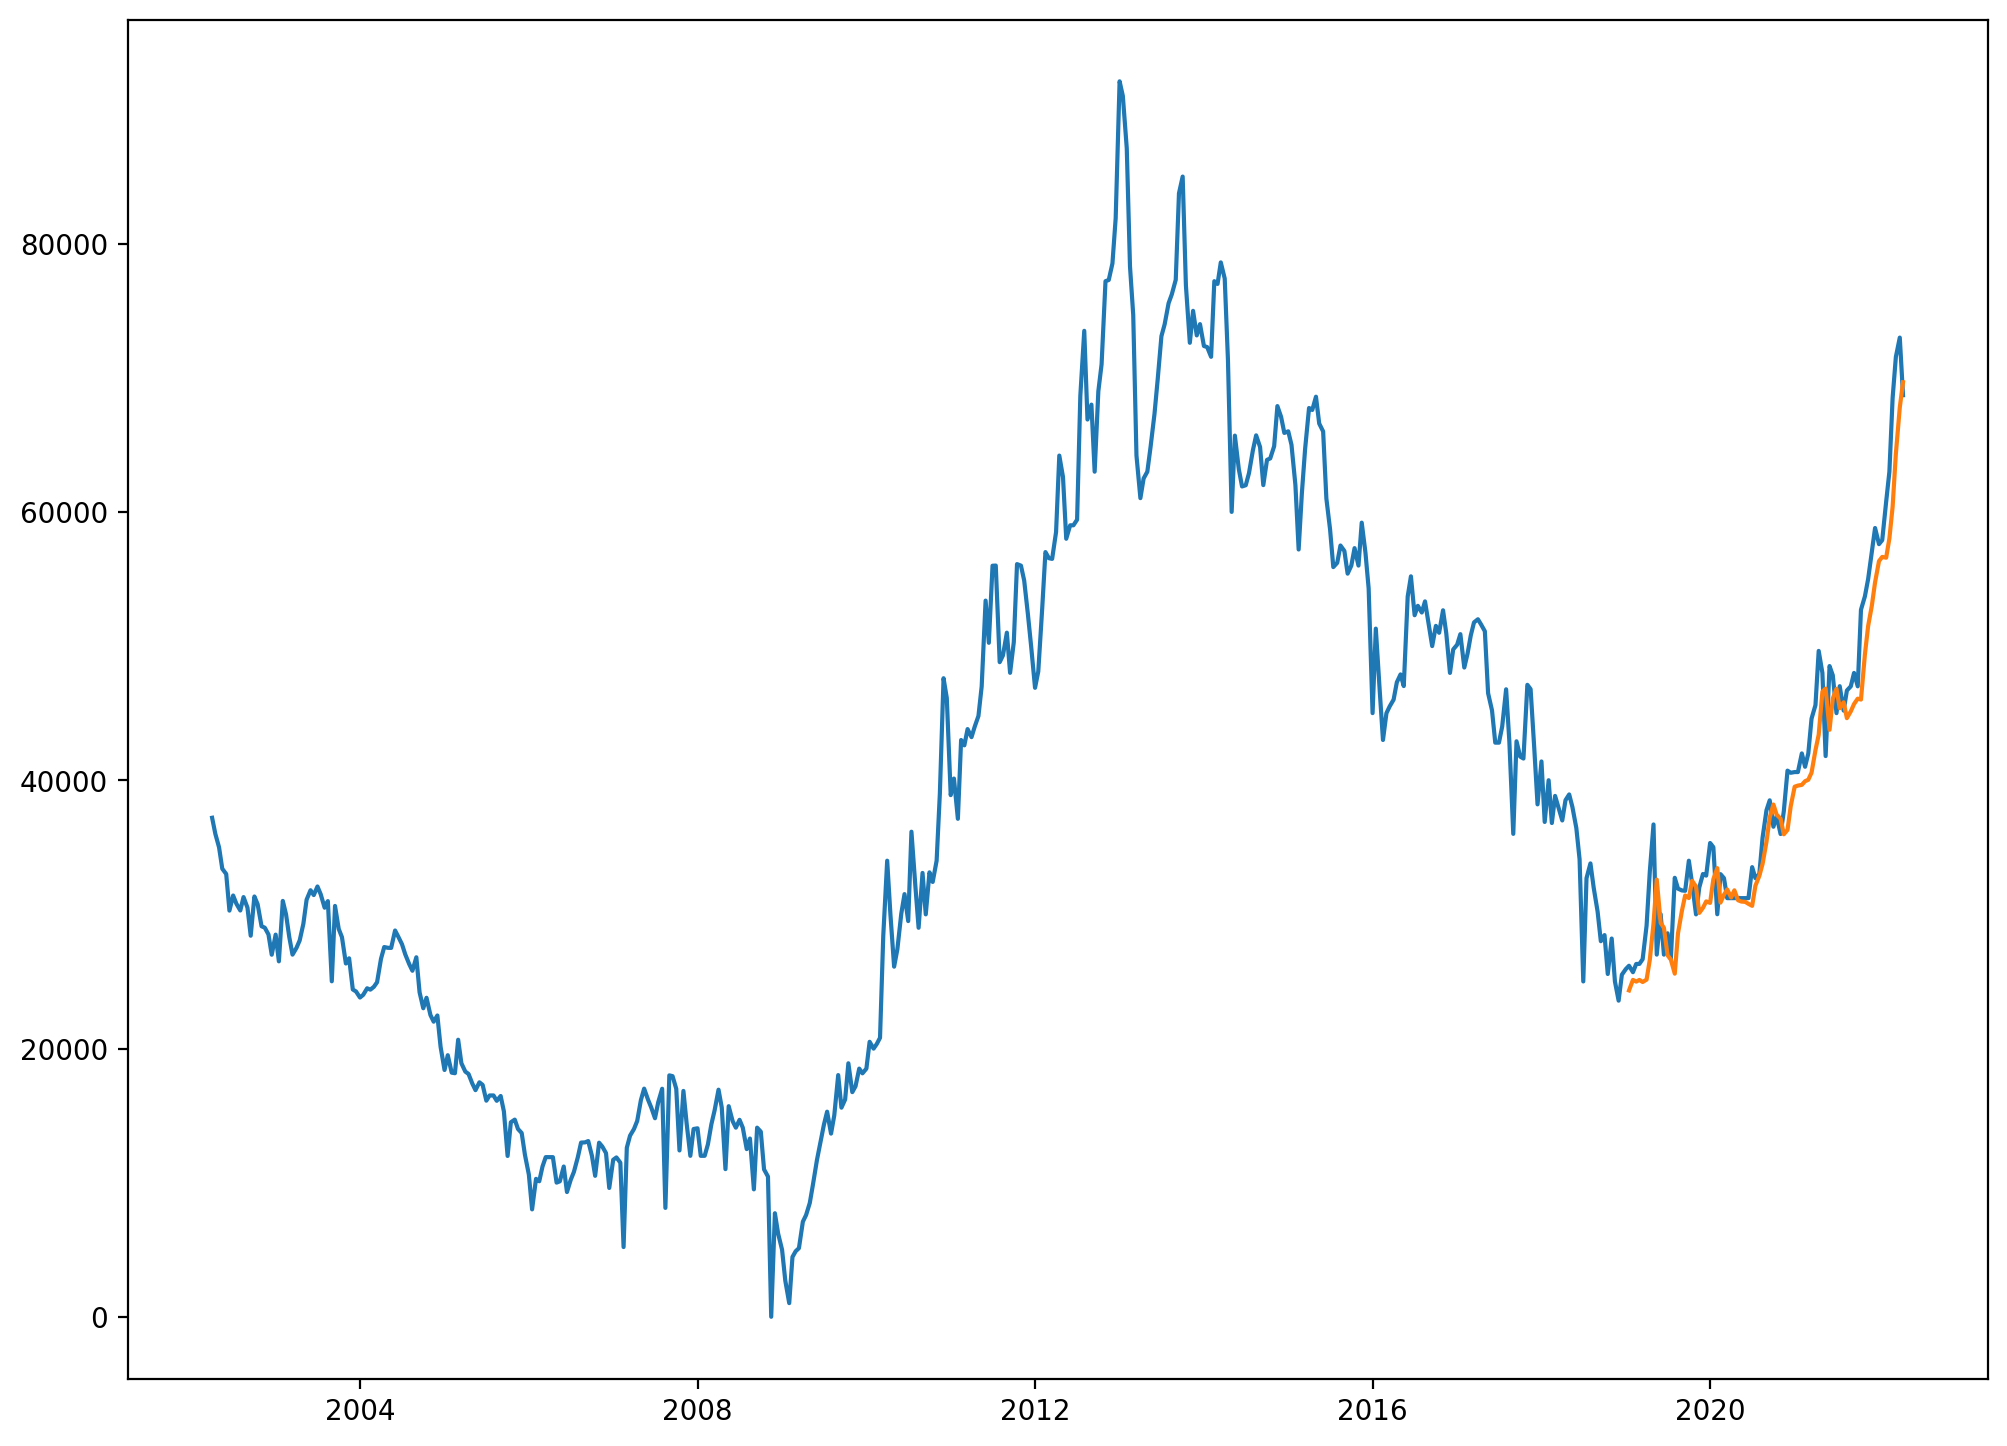

In [320]:
# Creating a plot for the predicted values
prediction_df3['date'] = model_cat_a_rnn[-79:].index
prediction_df3.set_index('date', inplace=True)

plt.figure(figsize=(12,9), dpi = 200)
plt.plot(model_cat_a_rnn['premium'])
plt.plot(prediction_df3);

In [321]:
# Adding the predictions of the 3rd Multivariate GRU model
prediction_df3['date'] = rnn_predict_df.index
prediction_df3.set_index('date', inplace=True)
rnn_predict_df['GRU_Multi3_Predictions'] = prediction_df3
rnn_predict_df

,premium,LSTM_Prediction,GRU_Predictions,GRU_Multi_Predictions,GRU_Multi2_Predictions,GRU_Multi3_Predictions
new_date,,,,,,
2019-01-15,26170.0,28209.458984,26900.830078,25025.610750,22962.083831,24331.044759
2019-02-01,25689.0,27569.478516,27400.701172,25585.089153,23203.277357,25115.272985
2019-02-15,26301.0,27106.443359,27281.144531,25295.396172,22835.124774,24988.515666
2019-03-01,26309.0,26771.681641,27505.580078,25378.877266,22862.297644,25112.907024
2019-03-15,26659.0,26542.412109,27665.109375,25548.449695,23181.739427,24957.025329
...,...,...,...,...,...,...
2022-02-15,63000.0,56974.265625,62398.953125,58574.948079,55427.325225,58025.309549
2022-03-01,68501.0,58305.750000,64817.832031,60930.830371,57856.387622,60392.851471
2022-03-15,71556.0,59982.769531,69614.687500,65041.327971,62018.650911,64339.010851


In [322]:
# Saving the predictions to csv
rnn_predict_df.to_csv('../data/rnn_predicted_values.csv', index=False)

In [324]:
# Adding the model performance to the summary df
summary_df.loc[10] = ['RNN - GRU 3',
                     'Multivariate',
                     10139610.50,
                     19.0]

summary_df

,Model,Univariate / Multivariate,MSE,Success %
0,ARIMA,Univariate,1.707664e+08,43.3
1,Linear Regression,Univariate,8.610584e+07,83.5
2,Linear Regression,Multivariate,6.277761e+08,100.0
3,Linear Regression w Lasso,Multivariate,6.291325e+08,100.0
4,Linear Regression w Ridge,Multivariate,6.291230e+08,100.0
5,SARIMA,Univariate,1.511497e+08,50.5
6,RNN - LSTM,Univariate,1.513375e+07,40.5
7,RNN - GRU,Univariate,7.453959e+06,75.9
8,RNN - GRU 1,Multivariate,8.823056e+06,20.3
9,RNN - GRU 2,Multivariate,1.914502e+07,5.1


In [325]:
# Saving the Summary df to csv
summary_df.to_csv('../data/summary_table2.csv', index=False)

Currently, while solely basing on MSE, the univariate GRU model is performing the best.

## Please proceed to the next notebook for error analysis